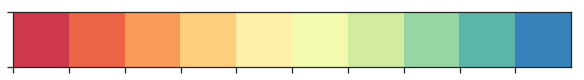

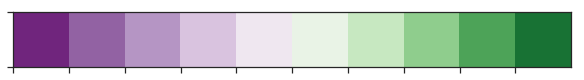

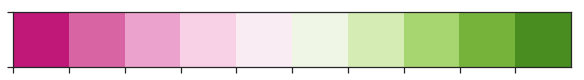

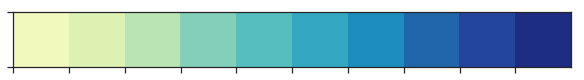

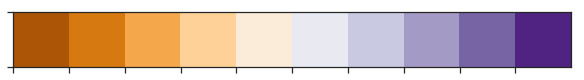

In [120]:
%matplotlib inline
import ast
from bs4 import BeautifulSoup
from config import api_key_tmdb
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import re
import requests
from scipy import stats
import seaborn as sns
sns.palplot(sns.color_palette("Spectral", 10))
sns.palplot(sns.color_palette("PRGn", 10))
sns.palplot(sns.color_palette("PiYG", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
sns.palplot(sns.color_palette("PuOr", 10))
import sqlite3
from sqlite3 import Error
import time
from wordcloud import WordCloud, STOPWORDS

In [121]:
# Importing the IMDB movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/imdb_movies_data.csv"
use_cols = ["imdb_id", "imdb_score", "meta_score"]

# Using pandas.read_csv method to load the file
imdb_df = pd.read_csv(data, usecols = use_cols)
imdb_df = imdb_df.set_index("imdb_id")

In [122]:
# Replace missing data in the "imdb_score" and "meta_score" columns with NumPy NaN values
imdb_df["imdb_score"] = imdb_df["imdb_score"].replace(" ", np.nan)
imdb_df["meta_score"] = imdb_df["meta_score"].replace(" ", np.nan)

In [123]:
# Importing the TMDB Movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/tmdb_movies_cast_df.csv"

# Using pandas.read_csv method to load the file
tmdb_df = pd.read_csv(data, lineterminator='\n')
tmdb_df = tmdb_df.set_index("id")
tmdb_df = tmdb_df.merge(imdb_df, how = "left", on = "imdb_id")

In [124]:
# Using pandas.to_numeric to coerce the "id", "budget" and "revenue" columns into numbers
tmdb_df["budget"] = pd.to_numeric(tmdb_df["budget"], downcast = "integer", errors = "coerce")
tmdb_df["revenue"] = pd.to_numeric(tmdb_df["revenue"], downcast = "integer", errors = "coerce")

# Lambda function to strip and split "release_date" string values
f = lambda x: str(x).strip().split('-')[0] if x != np.nan else np.nan

# Creating a new column, "year", and assigninf the value of "release_date" 
# After applying the lambda function through map
tmdb_df["year"] = tmdb_df["release_date"].map(f)

# Coerce the "year" column to integers
tmdb_df["year"] = pd.to_numeric(tmdb_df["year"], errors = "coerce")

# Convert "release_date" column to datetime format
tmdb_df["release_date"] = pd.to_datetime(tmdb_df["release_date"])

tmdb_df["title"] = tmdb_df["title"].astype("str")

tmdb_df["overview"] = tmdb_df["overview"].astype("str")

In [125]:
# Divide "release_date" column in months
tmdb_df["month_of_year"] = tmdb_df["release_date"].dt.month_name()

# Divide "release_date" column in months
tmdb_df["day_of_week"] = tmdb_df["release_date"].dt.day_name()

In [126]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8603 entries, 0 to 8602
Data columns (total 23 columns):
title                    8603 non-null object
belongs_to_collection    1516 non-null object
budget                   2529 non-null float64
genres                   8138 non-null object
imdb_id                  8603 non-null object
overview                 8603 non-null object
release_date             8557 non-null datetime64[ns]
revenue                  2020 non-null float64
tagline                  4544 non-null object
vote_average             7944 non-null float64
vote_count               7956 non-null float64
runtime                  8118 non-null float64
popularity               8603 non-null float64
production_companies     6793 non-null object
director_name            4691 non-null object
director_gender          4691 non-null float64
leading_actor_name       4314 non-null object
supporting_actor_name    4607 non-null object
imdb_score               8591 non-null object
meta

In [127]:
genres_df = tmdb_df[tmdb_df["genres"].notnull()][["title","budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score", "genres"]]
genres_df["genres"] = genres_df["genres"].apply(ast.literal_eval)


In [128]:
genres = genres_df["genres"]
genres = genres.apply(pd.Series)
genres = genres.rename(columns = lambda x : 'genre_' + str(x))
genres_df = pd.concat([genres_df[:], genres[:]], axis=1)

genres_df


,title,budget,revenue,runtime,year,month_of_year,day_of_week,popularity,imdb_score,meta_score,genres,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7
0,Spider-Man: Into the Spider-Verse,90000000.0,3.628236e+08,117.0,2018.0,December,Friday,115.129,8.5,87,"[Action, Adventure, Animation, Science Fiction...",Action,Adventure,Animation,Science Fiction,Comedy,NaN,NaN,NaN
1,Aquaman,160000000.0,1.143689e+09,144.0,2018.0,December,Friday,129.402,7.2,NaN,"[Action, Adventure, Fantasy, Science Fiction]",Action,Adventure,Fantasy,Science Fiction,NaN,NaN,NaN,NaN
2,Avengers: Infinity War,300000000.0,2.046240e+09,149.0,2018.0,April,Wednesday,129.988,8.5,68,"[Adventure, Action, Fantasy]",Adventure,Action,Fantasy,NaN,NaN,NaN,NaN,NaN
3,Bumblebee,135000000.0,4.203613e+08,114.0,2018.0,December,Saturday,226.241,7.0,66,"[Action, Adventure, Science Fiction]",Action,Adventure,Science Fiction,NaN,NaN,NaN,NaN,NaN
4,Dragged Across Concrete,15000000.0,NaN,159.0,2019.0,February,Thursday,34.986,7.4,63,"[Drama, Crime, Action, Thriller]",Drama,Crime,Action,Thriller,NaN,NaN,NaN,NaN
5,Deadpool 2,110000000.0,7.415474e+08,121.0,2018.0,May,Tuesday,42.911,7.8,66,"[Action, Comedy, Adventure]",Action,Comedy,Adventure,NaN,NaN,NaN,NaN,NaN
6,Mortal Engines,100000000.0,1.042365e+08,129.0,2018.0,November,Tuesday,70.197,6.2,NaN,"[Science Fiction, Action, Adventure, Fantasy, ...",Science Fiction,Action,Adventure,Fantasy,Thriller,NaN,NaN,NaN
7,Black Panther,200000000.0,1.346739e+09,134.0,2018.0,February,Tuesday,60.071,7.3,88,"[Action, Adventure, Fantasy, Science Fiction]",Action,Adventure,Fantasy,Science Fiction,NaN,NaN,NaN,NaN
8,Thor: Ragnarok,180000000.0,8.539771e+08,131.0,2017.0,October,Wednesday,54.183,7.9,74,"[Action, Adventure, Comedy, Fantasy, Science F...",Action,Adventure,Comedy,Fantasy,Science Fiction,NaN,NaN,NaN
9,Jurassic World: Fallen Kingdom,170000000.0,1.303460e+09,129.0,2018.0,June,Wednesday,37.211,6.2,NaN,"[Action, Adventure, Science Fiction]",Action,Adventure,Science Fiction,NaN,NaN,NaN,NaN,NaN


In [134]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
genres_df.sort_values("year", ascending = False)

,title,budget,revenue,runtime,year,month_of_year,day_of_week,popularity,imdb_score,meta_score,genres,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7
2655,False Flag,NaN,NaN,90.0,2019.0,March,Tuesday,1.596,6.4,NaN,"[Action, Drama]",Action,Drama,NaN,NaN,NaN,NaN,NaN,NaN
3268,ACAB - All Cops Are Bastards,NaN,NaN,113.0,2019.0,January,Thursday,2.107,7.9,NaN,"[Action, Drama]",Action,Drama,NaN,NaN,NaN,NaN,NaN,NaN
4,Dragged Across Concrete,15000000.0,NaN,159.0,2019.0,February,Thursday,34.986,7.4,63,"[Drama, Crime, Action, Thriller]",Drama,Crime,Action,Thriller,NaN,NaN,NaN,NaN
1367,Nicky Larson et le Parfum de Cupidon,NaN,NaN,NaN,2019.0,February,Wednesday,8.758,6.7,NaN,"[Adventure, Comedy]",Adventure,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
7183,Fist of Fury 2,NaN,NaN,145.0,2019.0,February,Friday,1.076,5.2,NaN,[Action],Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN
931,Revenger,NaN,NaN,102.0,2019.0,January,Sunday,2.995,5.6,NaN,"[Action, Crime]",Action,Crime,NaN,NaN,NaN,NaN,NaN,NaN
1682,Point Man,NaN,NaN,107.0,2019.0,February,Tuesday,1.116,4.4,NaN,"[Action, War]",Action,War,NaN,NaN,NaN,NaN,NaN,NaN
6504,Okkadu Migiladu,NaN,NaN,73.0,2019.0,February,Thursday,4.473,6.9,76,"[Animation, Adventure, Drama]",Animation,Adventure,Drama,NaN,NaN,NaN,NaN,NaN
279,Mard Ko Dard Nahi Hota,NaN,NaN,131.0,2019.0,March,Thursday,5.296,7.5,NaN,"[Action, Comedy]",Action,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
0,Spider-Man: Into the Spider-Verse,90000000.0,3.628236e+08,117.0,2018.0,December,Friday,115.129,8.5,87,"[Action, Adventure, Animation, Science Fiction...",Action,Adventure,Animation,Science Fiction,Comedy,NaN,NaN,NaN


In [78]:
most_successful_genre = genres_df.groupby("genre_0")["revenue"].mean()
most_successful_genre.sort_values(ascending = False)

genre_0
Adventure          2.130973e+08
Fantasy            2.067289e+08
Science Fiction    1.794285e+08
Family             1.749687e+08
Animation          1.401582e+08
War                1.217448e+08
Action             1.141235e+08
Mystery            1.114051e+08
Western            8.046736e+07
History            7.714252e+07
Thriller           6.493820e+07
Drama              5.650946e+07
Horror             5.136222e+07
Crime              4.915321e+07
Comedy             4.625548e+07
Romance            3.091876e+07
Music              2.979372e+07
Documentary                 NaN
TV Movie                    NaN
Name: revenue, dtype: float64

In [11]:
tmdb_df = tmdb_df.drop(["release_date"], axis=1)

In [12]:
tmdb_df_revenue = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score", 
                            "production_companies", "director_name", "leading_actor_name"]]

tmdb_df_revenue = tmdb_df_revenue.dropna(subset=["budget"])


In [13]:
tmdb_df_revenue["roi"] = ((tmdb_df_revenue["revenue"] - tmdb_df_revenue["budget"]) / tmdb_df_revenue["budget"])

In [14]:
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.budget < 5000].index)

In [15]:
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.revenue < 5000].index)

In [80]:
tmdb_df_revenue.sort_values("roi", ascending = False)

,title,budget,revenue,year,month_of_year,day_of_week,popularity,imdb_score,meta_score,production_companies,director_name,leading_actor_name,roi
980,The Way of the Dragon,130000.0,85000000.0,1972.0,June,Thursday,12.835,7.3,NaN,Orange Sky Golden Harvest,Bruce Lee,Bruce Lee,652.846154
241,Mad Max,400000.0,100000000.0,1979.0,April,Thursday,13.459,7.0,73,Kennedy Miller Productions,George Miller,Mel Gibson,249.000000
2982,Let's Do It Again,70000.0,11800000.0,1975.0,October,Saturday,1.786,6.9,NaN,First Artists,Sidney Poitier,Sidney Poitier,167.571429
2463,The Born Losers,360000.0,36000000.0,1967.0,August,Friday,2.314,6.1,NaN,Otis Productions,Tom Laughlin,Tom Laughlin,99.000000
3132,Cross Wars,225000.0,18000000.0,1974.0,August,Thursday,1.960,6.7,NaN,Max Baer Productions,NaN,NaN,79.000000
88,Star Wars,11000000.0,775398007.0,1977.0,May,Wednesday,34.989,8.6,90,Lucasfilm,George Lucas,Mark Hamill,69.490728
2083,Mary Kom,224056.0,15536328.0,2014.0,September,Friday,1.788,6.8,NaN,Viacom 18 Motion Pictures,Omung Kumar,Priyanka Chopra,68.341272
190,Dr. No,950000.0,59600000.0,1962.0,October,Thursday,24.453,7.3,78,United Artists,Terence Young,Sean Connery,61.736842
1244,Vanishing Point,1300000.0,72266306.0,1971.0,January,Friday,8.076,7.3,61,Cupid Productions,Richard C. Sarafian,Barry Newman,54.589466
8458,Bone Dry,37000.0,2000000.0,1998.0,October,Friday,0.600,6.7,NaN,Pak Nishan Films,NaN,NaN,53.054054


In [81]:
tmdb_df_revenue = tmdb_df_revenue.sort_values("roi")
tmdb_df_revenue

,title,budget,revenue,year,month_of_year,day_of_week,popularity,imdb_score,meta_score,production_companies,director_name,leading_actor_name,roi
990,Overdrive,28210303.0,7793.0,2017.0,June,Thursday,7.589,5.4,NaN,Umedia,Antonio Negret,Scott Eastwood,-0.999724
6633,Fireball 500,15000000.0,5290.0,2012.0,December,Monday,4.065,4.8,NaN,We Pictures,NaN,NaN,-0.999647
1293,Chaos,20000000.0,10289.0,2005.0,January,Monday,8.760,6.5,NaN,Mobius International,Tony Giglio,Jason Statham,-0.999486
2441,5 Days of War,20000000.0,17479.0,2011.0,April,Thursday,4.945,5.6,NaN,Dispictures,Renny Harlin,Rupert Friend,-0.999126
1924,Special Forces,10000000.0,10759.0,2011.0,November,Wednesday,7.819,6.4,NaN,Sofica Manon,Stéphane Rybojad,Diane Kruger,-0.998924
1760,Foodfight!,65000000.0,73706.0,2012.0,June,Friday,2.979,1.8,NaN,Threshold Entertainment,Lawrence Kasanoff,Charlie Sheen,-0.998866
2155,Welcome to the Punch,8500000.0,9747.0,2013.0,March,Friday,6.382,6.1,NaN,Worldview Entertainment,Eran Creevy,James McAvoy,-0.998853
1490,Cherry 2000,10000000.0,14000.0,1987.0,November,Thursday,9.427,5.5,NaN,Orion Pictures,Steve De Jarnatt,Melanie Griffith,-0.998600
3636,Making Contact,15000000.0,23000.0,2001.0,October,Sunday,1.753,4.6,NaN,Atlantic Streamline,Roland Emmerich,Joshua Morrell,-0.998467
2403,The Red Baron,18000000.0,40239.0,2008.0,March,Saturday,7.196,6.4,NaN,Niama Film,Nikolai Müllerschön,Matthias Schweighöfer,-0.997765


In [18]:
most_successful_pc_roi = tmdb_df_revenue.groupby("production_companies")["roi"].mean()
most_successful_pc_roi.sort_values(ascending = False)

production_companies
First Artists                           167.571429
Orange Sky Golden Harvest               136.104790
Otis Productions                         99.000000
Kennedy Miller Productions               87.641146
Max Baer Productions                     79.000000
Cupid Productions                        54.589466
Pak Nishan Films                         53.054054
The Universal Film Mfg. Co.              39.000000
Viacom 18 Motion Pictures                35.534272
Aamir Khan Productions                   28.807692
Spring Era Film Company                  28.303794
Carolco International N.V.               25.131792
D'Antoni Productions                     21.865976
Tatira-Hiller Productions                19.280000
Foster-Brower Productions                16.549982
Kent Productions                         15.912624
Sil-Metropole Organisation Ltd.          15.600191
United Artists                           15.479555
Fuji Television Network                  15.428591
Diablo Ent

In [19]:
most_successful_pc_rev = tmdb_df.groupby("production_companies")["revenue"].mean()
most_successful_pc_rev.sort_values(ascending = False)

production_companies
Truenorth Productions                                   2.068224e+09
Abu Dhabi Film Commission                               1.506249e+09
Illumination Entertainment                              1.156731e+09
Ingenious Film Partners                                 1.078562e+09
Danjaq                                                  9.946178e+08
Hasbro Studios                                          9.402898e+08
Blue Sky Studios                                        8.866868e+08
Marvel Studios                                          8.714689e+08
Spring Era Film Company                                 8.703227e+08
Avi Arad Productions                                    8.550140e+08
Etalon film                                             7.886798e+08
Heineken Branded Entertainment                          7.385997e+08
Fuji Television Network                                 6.516815e+08
Pixar                                                   6.314421e+08
GH Three     

In [135]:
# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()

In [136]:
# Use create_connection function to create Database
create_connection("/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/movies.db")

In [137]:
# Create a connection object using the connect function 
# To establish a connection with "movies.db"
connection = sqlite3.connect("movies.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

In [145]:
# Write records stored in the imdb_df DataFrame to a SQL database
imdb_df.to_sql("imdb_movies", con = connection)

In [ ]:
# Write records stored in the tmdb_df DataFrame to a SQL database
tmdb_df.to_sql("tmdb_movies", con = connection)

In [214]:
combined_df = pd.read_sql_query('''
SELECT
    id,
    title, 
    belongs_to_collection, 
    budget, 
    genres,
    overview, 
    revenue, 
    tagline, 
    director_name,
    leading_actor_name,
    supporting_actor_name,
    vote_average, 
    vote_count, 
    runtime, 
    popularity, 
    production_companies,
    year,
    month_of_year,
    day_of_week,
    tmdb_movies.imdb_id AS tmdb_imdb_id,
    imdb_movies.imdb_id AS imdb_id,
    imdb_score
    meta_score
FROM
    tmdb_movies
    INNER JOIN imdb_movies ON tmdb_movies.imdb_id = imdb_movies.imdb_id;''', connection)

In [138]:
pd.read_sql_query('''SELECT title, MAX(popularity) FROM tmdb_movies''', connection)

,title,MAX(popularity)
0,Bumblebee,226.241


In [216]:
pd.read_sql_query('''SELECT title, MAX(revenue) FROM tmdb_movies''', connection)

,title,MAX(revenue)
0,Avatar,2.787965e+09


In [217]:
pd.read_sql_query('''SELECT title, MAX(budget) FROM tmdb_movies''', connection)

,title,MAX(budget)
0,Justice League,500000000.0


In [218]:
pd.read_sql_query('''SELECT title, MIN(budget) FROM tmdb_movies''', connection)

,title,MIN(budget)
0,The Hunted,1.0


In [340]:
pd.read_sql_query('''SELECT title, MIN(popularity) FROM tmdb_movies''', connection)

,title,MIN(popularity)
0,Resident Evil: Afterlife,0.6


In [144]:
pd.read_sql_query('''SELECT title, revenue, budget, vote_count, year, genres FROM tmdb_movies WHERE production_companies LIKE "%lionsgate%";''', connection)

,title,revenue,budget,vote_count,year,genres
0,Power Rangers,142337240.0,100000000.0,2569.0,2017.0,"['Action', 'Adventure', 'Science Fiction']"
1,Sicario,84025816.0,30000000.0,4311.0,2015.0,"['Action', 'Crime', 'Thriller']"
2,The Hunger Games,691210692.0,75000000.0,14140.0,2012.0,"['Science Fiction', 'Adventure', 'Fantasy']"
3,The Hunger Games: Catching Fire,847423452.0,130000000.0,10790.0,2013.0,"['Adventure', 'Action', 'Science Fiction']"
4,Abduction,82087155.0,35000000.0,1720.0,2011.0,"['Thriller', 'Action', 'Mystery']"
5,The Hunger Games: Mockingjay - Part 1,752100229.0,125000000.0,9756.0,2014.0,"['Science Fiction', 'Adventure', 'Thriller']"
6,3:10 to Yuma,70016220.0,55000000.0,1779.0,2007.0,['Western']
7,Hummingbird,8352885.0,20000000.0,823.0,2013.0,"['Action', 'Thriller']"
8,Punisher: War Zone,10089373.0,20500000.0,518.0,2008.0,"['Action', 'Crime']"
9,Crank: High Voltage,34560577.0,20000000.0,1377.0,2009.0,"['Action', 'Thriller', 'Crime']"


In [24]:
tmdb_runtime = tmdb_df[tmdb_df["runtime"] > 0][["runtime", "year", "popularity", "imdb_score", 
                                                "meta_score", "budget", "revenue"]].sort_values("popularity", ascending = False)

In [25]:
tmdb_df_rel = tmdb_df[tmdb_df["imdb_id"].notnull()][["title", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

tmdb_df_revenue_rel = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity"]]

/Users/florencialeoni/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/florencialeoni/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


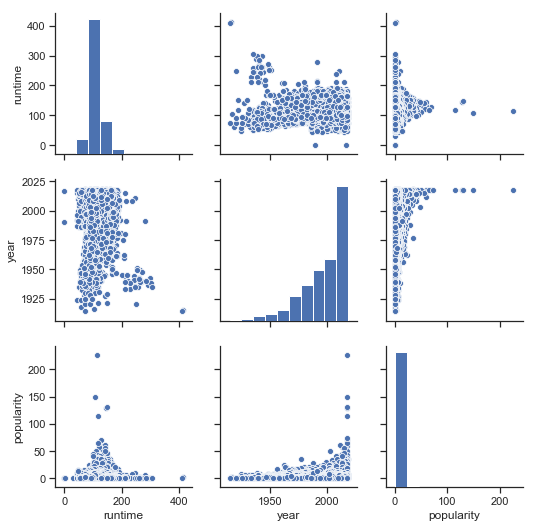

In [26]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(tmdb_df_rel)

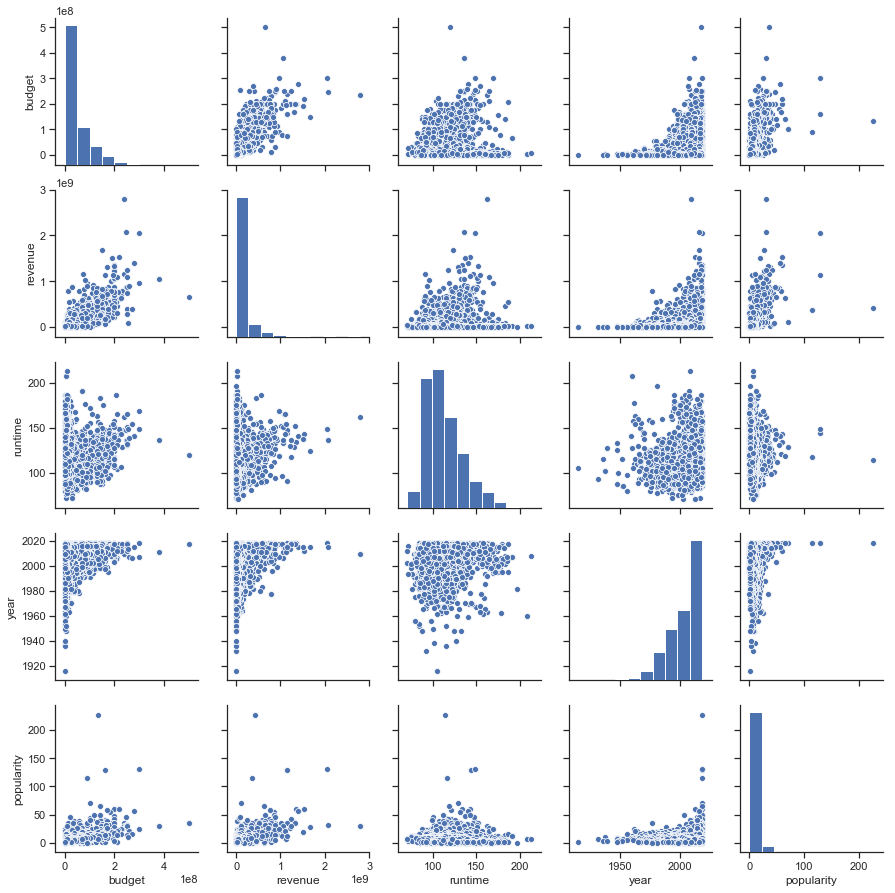

In [27]:
sns.pairplot(tmdb_df_revenue_rel)

In [28]:
less_popular = tmdb_df[tmdb_df["popularity"].notnull()][["title", "tagline", 
                        "popularity", "year", "overview", "director_name", 
                            "leading_actor_name", "supporting_actor_name", "budget"]].sort_values("popularity").head(100)

In [29]:
less_popular_title = pd.Series(' '.join(less_popular["title"]).lower().split()).value_counts()[:200]

In [30]:
less_popular_overview = pd.Series(' '.join(less_popular["overview"]).lower().split()).value_counts()[:200]

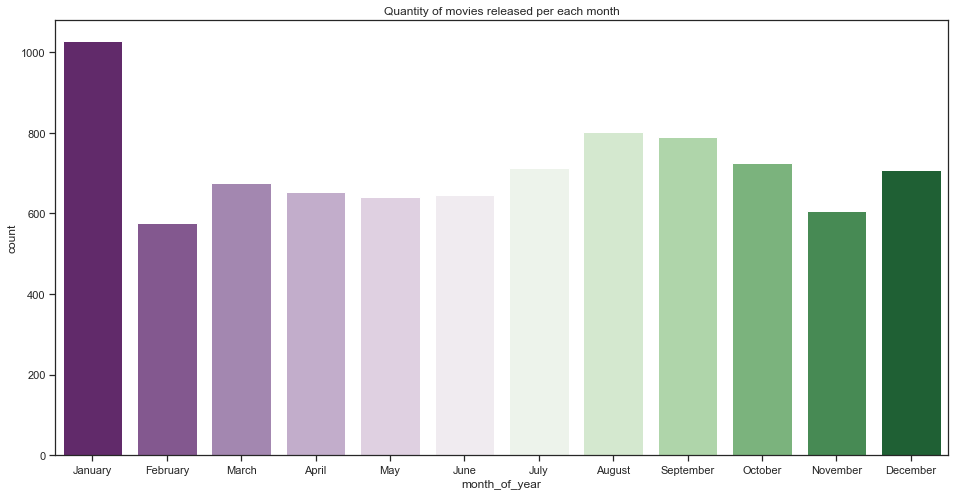

In [31]:
plt.figure(figsize=(16,8))
plt.title("Quantity of movies released per each month")
sns.countplot(x = "month_of_year", data = tmdb_df, palette = "PRGn", order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])

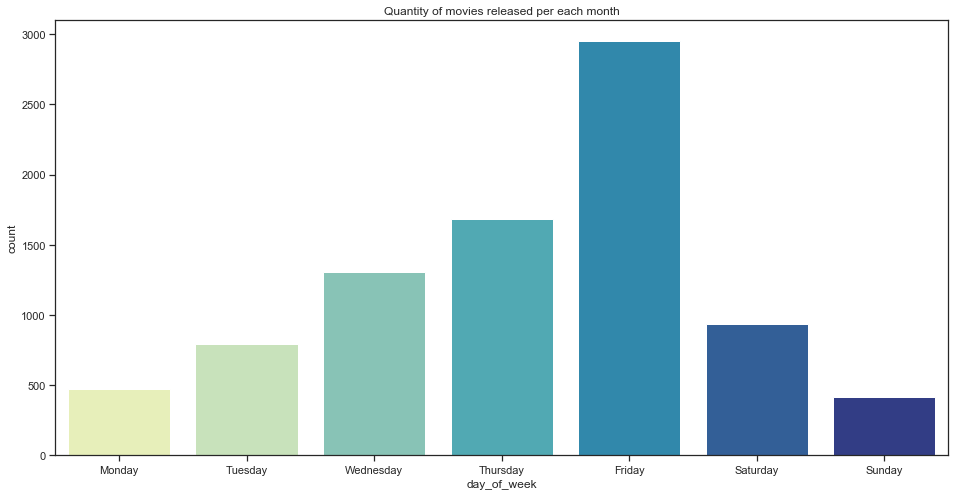

In [32]:
plt.figure(figsize=(16,8))
plt.title("Quantity of movies released per each month")
sns.countplot(x = "day_of_week", data = tmdb_df, palette = "YlGnBu", order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])

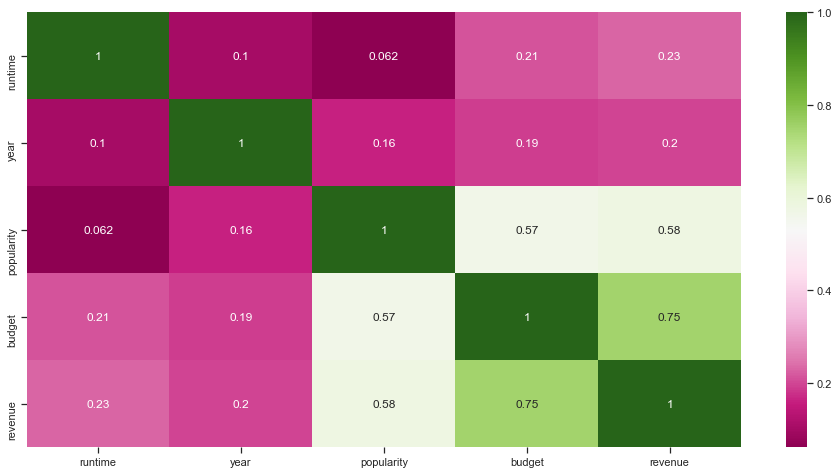

In [33]:
plt.figure(figsize = (16, 8))
sns.heatmap(tmdb_runtime.corr(), annot = True, cmap = "PiYG")

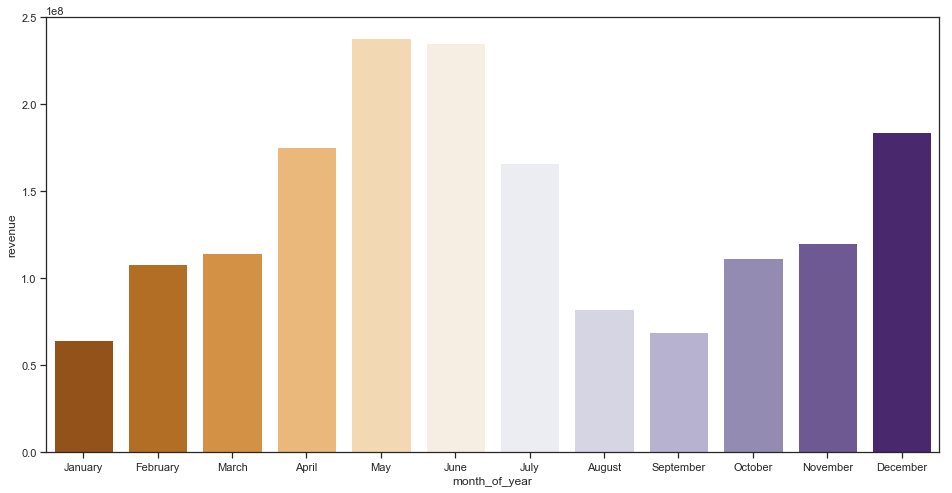

In [34]:
month_df = tmdb_df_revenue[tmdb_df_revenue["month_of_year"].notnull()][["revenue", "month_of_year"]]
avg_rev_month = month_df.groupby("month_of_year").mean()
avg_rev_month.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = "month_of_year", y = "revenue", palette = "PuOr", data = avg_rev_month, order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])

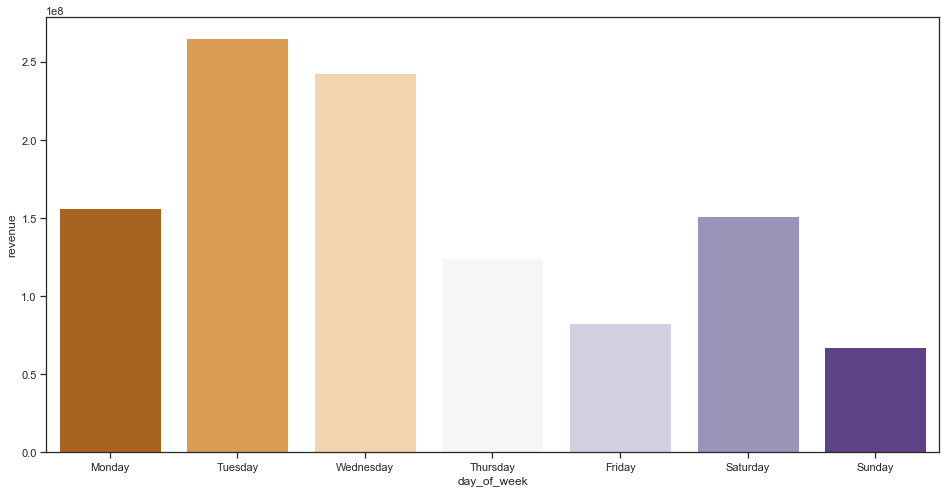

In [35]:
day_df = tmdb_df_revenue[tmdb_df_revenue["day_of_week"].notnull()][["revenue", "day_of_week"]]
avg_rev_day = day_df.groupby("day_of_week").mean()
avg_rev_day.reset_index(inplace = True)
plt.figure(figsize = (16, 8))
sns.barplot(x = "day_of_week", y = "revenue", palette = "PuOr", data = avg_rev_day, order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])

In [114]:
filtered_genres_df = genres_df[genres_df['year'] < 2012]
grouped_by = filtered_genres_df.groupby(["genre_0"])["revenue"].mean()

grouped_by.mean().plot(kind = "bar", stacked = False, figsize = (14, 6))
grouped_by


# DataFrameGroupBy.plot(most_successful_genre, x = "genre_0", y = "revenue")
# df.groupby(['state','gender'])['name'].size().unstack().plot(kind='bar',stacked=True)
# most_successful_genre.reset_index(inplace = True)
# sns.catplot(x = "genre_0", y = "revenue", kind = "swarm", data = most_successful_genre, palette = "PiYG");


genre_0
Action             7.943091e+07
Adventure          1.905062e+08
Animation          1.511780e+08
Comedy             5.219657e+07
Crime              3.880232e+07
Documentary                 NaN
Drama              5.334698e+07
Family             5.472943e+07
Fantasy            1.640205e+08
History            1.197001e+08
Horror             6.558213e+07
Music              2.215944e+07
Mystery            8.507212e+07
Romance            3.670327e+07
Science Fiction    1.062726e+08
Thriller           7.742510e+07
War                2.963419e+07
Western            3.521905e+07
Name: revenue, dtype: float64

In [96]:
pd.Series(' '.join(less_popular["title"]).lower().split()).value_counts()[:15]


the      29
of        6
and       3
on        3
in        3
heist     2
red       2
2:        2
other     2
hard      2
devil     2
for       2
girl      2
a         2
kasam     1
dtype: int64

In [99]:
pd.Series(' '.join(less_popular["overview"]).lower().split()).value_counts()[:100]

the         255
a           219
to          184
and         159
of          135
in          109
is          106
his          90
he           77
with         58
for          47
by           43
who          37
an           36
that         36
her          35
as           33
but          31
are          28
him          28
on           26
from         26
she          24
when         23
they         22
be           21
after        21
police       19
their        19
out          17
           ... 
her.          7
boy           7
years         7
have          7
so            7
very          6
local         6
son           6
can           6
drug          6
three         6
war           6
criminal      6
mother        6
movie         6
through       6
best          6
meets         6
become        6
do            6
father        6
little        6
wife          6
named         6
must          5
rescue        5
new           5
time          5
him.          5
tries         5
Length: 100, dtype: int6